In [132]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
base = '/Users/maxv/Dropbox (MIT)/inferring_expectations/'
community = gpd.read_file(base + 'data/calenviroscreen40shpf2021shp/')
community = community.to_crs("EPSG:4328")
community.head()

,Tract,ZIP,County,ApproxLoc,TotPop19,CIscore,CIscoreP,Ozone,OzoneP,PM2_5,...,Elderly65,Hispanic,White,AfricanAm,NativeAm,OtherMult,Shape_Leng,Shape_Area,AAPI,geometry
0,6.083002e+09,93454,Santa Barbara,Santa Maria,4495,36.019653,69.162885,0.034190,10.566273,7.567724,...,12.5028,68.9210,20.8899,0.4004,0.2670,1.3126,6999.357689,2.847611e+06,8.2091,"POLYGON ((-2651581.10264 -4513022.35508, -2650..."
1,6.083002e+09,93455,Santa Barbara,Santa Maria,13173,37.030667,70.637922,0.035217,11.561917,7.624775,...,5.3519,78.6229,13.2240,2.5051,0.0000,0.9489,19100.578232,1.635292e+07,4.6990,"POLYGON ((-2651581.10264 -4513022.35508, -2652..."
2,6.083002e+09,93454,Santa Barbara,Santa Maria,2398,31.213140,61.069087,0.034190,10.566273,7.548835,...,12.8857,65.7214,30.6088,0.9591,0.0000,2.1685,4970.985897,1.352329e+06,0.5421,"POLYGON ((-2649904.16938 -4513478.61304, -2650..."
3,6.083002e+09,93455,Santa Barbara,Orcutt,4496,6.639331,5.988401,0.036244,13.615432,7.660570,...,14.4128,22.9537,69.1948,0.9342,0.7117,2.5356,6558.956012,2.417717e+06,3.6699,"POLYGON ((-2651349.71329 -4517535.18368, -2651..."
4,6.083002e+09,93455,Santa Barbara,Orcutt,4008,14.022852,23.121533,0.036244,13.615432,7.663210,...,18.8872,33.4082,59.7804,0.6986,1.4721,1.3723,6570.368730,2.608422e+06,3.2685,"POLYGON ((-2653175.96901 -4516448.43345, -2652..."


In [134]:
sensitive_pop = ['Asthma','LowBirtWt','Cardiovas']
socioecon_pop = ['Educatn','Ling_Isol', 'Poverty', 'Unempl', 'HousBurd']
all_factors = sensitive_pop + socioecon_pop + ['TotPop19']
community[all_factors]

,Asthma,LowBirtWt,Cardiovas,Educatn,Ling_Isol,Poverty,Unempl,HousBurd,TotPop19
0,82.18,6.01,12.69,30.4,18.2,57.5,3.1,21.6,4495
1,48.80,4.00,7.60,44.0,18.2,51.0,7.2,19.3,13173
2,82.18,4.95,12.69,30.2,13.3,29.4,4.3,17.9,2398
3,41.11,2.65,10.31,2.9,0.0,8.8,6.1,10.6,4496
4,41.11,6.22,10.31,10.1,4.3,20.4,12.1,9.5,4008
...,...,...,...,...,...,...,...,...,...
8030,48.33,2.72,11.22,6.4,7.0,18.9,1.2,15.4,5339
8031,18.84,3.48,7.73,4.5,13.6,23.2,4.0,17.7,4365
8032,46.90,3.91,10.87,16.0,10.1,32.2,6.2,13.3,6758
8033,54.25,5.87,23.93,42.6,21.7,59.9,9.1,20.4,6986


In [43]:
ica_db = gpd.read_file(base + 'data/all_ica_maps/').to_crs("EPSG:4328")
ica_db.head()

,clean_name,Utility,geometry
0,abacus,SCE,MULTILINESTRING ((-2411348.62820 -4689954.9347...
1,abraham,SCE,MULTILINESTRING ((-2534555.43800 -4614110.3816...
2,academy,SCE,MULTILINESTRING ((-2546514.34245 -4614176.9166...
3,acadian,SCE,MULTILINESTRING ((-2400690.07776 -4723645.4270...
4,acapulco,SCE,MULTILINESTRING ((-2469528.18788 -4673513.5523...


In [135]:
out_df = None
for i, row in ica_db.iterrows():
    cbg_matches = community[community.intersects(row.geometry)]
    row = pd.DataFrame(row).transpose().drop(columns=['geometry'])
    if len(cbg_matches) == 0:
        print("0 matches: ", row.clean_name, row.Utility)
    else:
        length = cbg_matches.length.values.flatten()
        for var in all_factors:
            if all(cbg_matches[var] == -999):
                row[var] = np.nan
                continue
            not_nan = cbg_matches[var] != -999
            row[var] = np.average(cbg_matches[var][not_nan], weights=length[not_nan])
    if out_df is None:
        out_df = row
    else:
        out_df = out_df.append(row)
for var in sensitive_pop + socioecon_pop:
    out_df[var + '_P'] = 100 * out_df[var].rank(pct=True)
out_df['sens'] = np.mean(out_df[[var + '_P' for var in sensitive_pop]], axis=1)
out_df['socio'] = np.mean(out_df[[var + '_P' for var in socioecon_pop]], axis=1)
out_df['PopChar'] = np.mean(out_df[['sens','socio']], axis=1)
out_df['PopChar_P'] = 100 * out_df['PopChar'].rank(pct=True)
out_df['Utility'] = np.where(out_df.Utility == 'PGE', 'PG&E', out_df.Utility)
out_df['Utility'] = np.where(out_df.Utility == 'SDGE', 'SDG&E', out_df.Utility)
out_df.to_csv(base + 'data/community_with_circuit.csv', index=False)
out_df.head()

0 matches:  438    hi line
Name: clean_name, dtype: object 438    SCE
Name: Utility, dtype: object
0 matches:  476    interior
Name: clean_name, dtype: object 476    SCE
Name: Utility, dtype: object
0 matches:  1070    wrigley
Name: clean_name, dtype: object 1070    SCE
Name: Utility, dtype: object
0 matches:  1082    18th street 0401
Name: clean_name, dtype: object 1082    PG&E
Name: Utility, dtype: object
0 matches:  1083    18th street 0402
Name: clean_name, dtype: object 1083    PG&E
Name: Utility, dtype: object
0 matches:  1084    21st avenue 0401
Name: clean_name, dtype: object 1084    PG&E
Name: Utility, dtype: object
0 matches:  1085    21st avenue 0402
Name: clean_name, dtype: object 1085    PG&E
Name: Utility, dtype: object
0 matches:  1086    21st avenue 0403
Name: clean_name, dtype: object 1086    PG&E
Name: Utility, dtype: object
0 matches:  1087    6th avenue 0401
Name: clean_name, dtype: object 1087    PG&E
Name: Utility, dtype: object
0 matches:  1088    6th avenue 0402

0 matches:  1797    east grand 1108
Name: clean_name, dtype: object 1797    PG&E
Name: Utility, dtype: object
0 matches:  1798    east grand 1109
Name: clean_name, dtype: object 1798    PG&E
Name: Utility, dtype: object
0 matches:  1800    east grand 1111
Name: clean_name, dtype: object 1800    PG&E
Name: Utility, dtype: object
0 matches:  1801    east grand 1112
Name: clean_name, dtype: object 1801    PG&E
Name: Utility, dtype: object
0 matches:  1802    east grand 1113
Name: clean_name, dtype: object 1802    PG&E
Name: Utility, dtype: object
0 matches:  1803    east grand 1115
Name: clean_name, dtype: object 1803    PG&E
Name: Utility, dtype: object
0 matches:  1850    el cerrito g 1101
Name: clean_name, dtype: object 1850    PG&E
Name: Utility, dtype: object
0 matches:  1851    el cerrito g 1102
Name: clean_name, dtype: object 1851    PG&E
Name: Utility, dtype: object
0 matches:  1852    el cerrito g 1103
Name: clean_name, dtype: object 1852    PG&E
Name: Utility, dtype: object
0 ma

0 matches:  3119    ralston 1101
Name: clean_name, dtype: object 3119    PG&E
Name: Utility, dtype: object
0 matches:  3120    ralston 1102
Name: clean_name, dtype: object 3120    PG&E
Name: Utility, dtype: object
0 matches:  3133    redwood city 0402
Name: clean_name, dtype: object 3133    PG&E
Name: Utility, dtype: object
0 matches:  3134    redwood city 0403
Name: clean_name, dtype: object 3134    PG&E
Name: Utility, dtype: object
0 matches:  3135    redwood city 0404
Name: clean_name, dtype: object 3135    PG&E
Name: Utility, dtype: object
0 matches:  3136    redwood city 0405
Name: clean_name, dtype: object 3136    PG&E
Name: Utility, dtype: object
0 matches:  3137    redwood city 0406
Name: clean_name, dtype: object 3137    PG&E
Name: Utility, dtype: object
0 matches:  3138    redwood city 0408
Name: clean_name, dtype: object 3138    PG&E
Name: Utility, dtype: object
0 matches:  3139    redwood city 0409
Name: clean_name, dtype: object 3139    PG&E
Name: Utility, dtype: object
0 

0 matches:  3487    sf k 0404
Name: clean_name, dtype: object 3487    PG&E
Name: Utility, dtype: object
0 matches:  3488    sf k 0405
Name: clean_name, dtype: object 3488    PG&E
Name: Utility, dtype: object
0 matches:  3489    sf k 0406
Name: clean_name, dtype: object 3489    PG&E
Name: Utility, dtype: object
0 matches:  3493    sf k 0410
Name: clean_name, dtype: object 3493    PG&E
Name: Utility, dtype: object
0 matches:  3496    sf l 0401
Name: clean_name, dtype: object 3496    PG&E
Name: Utility, dtype: object
0 matches:  3499    sf l 0404
Name: clean_name, dtype: object 3499    PG&E
Name: Utility, dtype: object
0 matches:  3508    sf m 0401
Name: clean_name, dtype: object 3508    PG&E
Name: Utility, dtype: object
0 matches:  3509    sf m 0402
Name: clean_name, dtype: object 3509    PG&E
Name: Utility, dtype: object
0 matches:  3510    sf m 0403
Name: clean_name, dtype: object 3510    PG&E
Name: Utility, dtype: object
0 matches:  3511    sf m 0404
Name: clean_name, dtype: object 35

,clean_name,Utility,Asthma,LowBirtWt,Cardiovas,Educatn,Ling_Isol,Poverty,Unempl,HousBurd,...,Cardiovas_P,Educatn_P,Ling_Isol_P,Poverty_P,Unempl_P,HousBurd_P,sens,socio,PopChar,PopChar_P
0,abacus,SCE,47.740000,7.240000,15.020000,7.100000,1.500000,35.500000,11.400000,16.500000,...,70.974701,30.041314,20.727309,73.806683,90.416063,78.289738,77.983912,58.656221,68.320067,80.074524
1,abraham,SCE,26.925189,4.090000,6.338487,12.557217,21.300000,21.617963,19.317658,18.221090,...,4.981369,59.335038,96.463635,40.811456,99.047816,87.565392,20.996286,76.644667,48.820477,50.088253
2,academy,SCE,43.727445,4.560589,12.069560,23.685322,7.958909,25.968563,3.417190,16.475274,...,53.226123,85.677749,79.623322,50.974543,18.050093,78.148893,53.260505,62.494920,57.877713,65.071583
3,acadian,SCE,92.122087,5.147343,26.503260,18.844525,1.229234,42.760364,8.141004,20.910904,...,99.068445,79.352744,16.399519,86.426014,75.501966,94.657948,85.917253,70.467638,78.192446,92.067072
4,acapulco,SCE,41.379488,3.880970,13.025644,7.862241,4.933974,18.564959,5.322233,12.251395,...,58.227103,34.113712,62.973352,33.711217,48.168081,44.828974,46.722876,44.759067,45.740972,43.890959


/opt/homebrew/Caskroom/miniforge/base/envs/mypy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


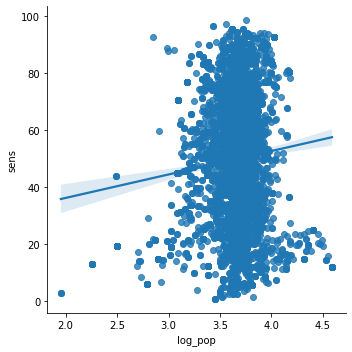

In [141]:
import matplotlib.pyplot as plt 
import seaborn as sns
out_df['log_pop'] = np.log10(out_df['TotPop19'])
sns.lmplot('log_pop','sens',data=out_df)

In [142]:
import os
import sys
if ('Users/maxv' in os.getcwd()):
    base = "/Users/maxv/Dropbox (MIT)/inferring_expectations/" 
else:
    base = '/pool001/vilgalys/inferring_expectations/'
sys.path.append(os.path.abspath(base + "code/"))
import global_constants
import read_write
psps_db = read_write.read_psps(merge_community=True,return_db=True)

In [143]:
psps_db.head()

,clean_name,Utility,Outage Sta,Full Resto,Outage Dur,Outage Day,Outage Hou,Circuit Na,HFTD,TOTAL CUST,...,Cardiovas_P,Educatn_P,Ling_Isol_P,Poverty_P,Unempl_P,HousBurd_P,sens,socio,PopChar,PopChar_P
0,accent,SCE,1/19/21 12:40,1/19/21 21:54,"0 days,9 hrs,13 min",0.385,9.23,ACCENT,T2,1584,...,75.053932,53.078890,64.696454,37.649165,63.547920,47.424547,72.508591,53.279395,62.893993,73.347715
1,acosta,SCE,10/10/19 8:14,10/12/19 10:05,"2 days,1 hrs,51 min",2.077,49.85,ACOSTA,Tier 2/Tier 3,5,...,57.932928,44.658666,25.225406,54.912490,57.524322,66.237425,59.766471,49.711662,54.739066,59.560698
2,acosta,SCE,10/24/19 4:48,10/25/19 14:28,"1 days,9 hrs,40 min",1.403,33.67,Acosta 12kV,Tier 2/Tier 3,1243,...,57.932928,44.658666,25.225406,54.912490,57.524322,66.237425,59.766471,49.711662,54.739066,59.560698
3,acosta,SCE,10/28/19 6:49,10/29/19 9:55,"1 days,3 hrs,6 min",1.129,27.10,ACOSTA,None,1243,...,57.932928,44.658666,25.225406,54.912490,57.524322,66.237425,59.766471,49.711662,54.739066,59.560698
4,acosta,SCE,10/30/19 1:30,11/1/19 11:53,"2 days,10 hrs,23 min",2.433,58.38,ACOSTA,None,1243,...,57.932928,44.658666,25.225406,54.912490,57.524322,66.237425,59.766471,49.711662,54.739066,59.560698


/opt/homebrew/Caskroom/miniforge/base/envs/mypy/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


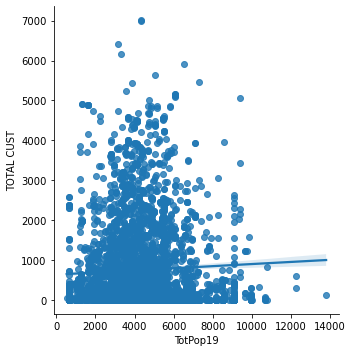

In [144]:
sns.lmplot('TotPop19','TOTAL CUST', data=psps_db)

In [152]:
import statsmodels.formula.api as smf
psps_db['total_cust'] = psps_db['TOTAL CUST']
smf.ols('total_cust ~ (TotPop19 + sens + socio):C(Utility)', data=psps_db).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             total_cust   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     97.82
Date:                Sun, 14 Aug 2022   Prob (F-statistic):          8.67e-168
Time:                        18:27:39   Log-Likelihood:                -38393.
No. Observations:                4631   AIC:                         7.681e+04
Df Residuals:                    4621   BIC:                         7.687e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    958.8839     66.639     14.389      0.000     828.240    1089.528
TotPop19:C(Utility)[PG&E]      0.0734      0.012      6.168      0.000       0.050       0.097
TotPop19:C(Utility)[SCE]      -0.0194      0.011     -1.821      0.069      -0.040       0.001
TotPop19:C(Utility)[SDG&E]     0.1278      0.030      4.216      0.000       0.068       0.187
sens:C(Utility)[PG&E]         -9.4070      1.300     -7.234      0.000     -11.956      -6.858
sens:C(Utility)[SCE]          -3.8674      0.942     -4.104      0.000      -5.715      -2.020
sens:C(Utility)[SDG&E]       -19.8487      4.255     -4.664      0.000     -28.191     -11.506
socio:C(Utility)[PG&E]         6.3487      1.541      4.121      0.000       3.328       9.369
socio:C(Utility)[SCE]         -6.0587      1.177     -5.149      0.000      -8.365      -3.752
socio:C(Utility)[SDG&E]       -6.2949      2.264     -2.781      0.005     -10.733      -1.857
==============================================================================
Omnibus:                     1570.312   Durbin-Watson:                   1.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5139.951
Skew:                           1.730   Prob(JB):                         0.00
Kurtosis:                       6.830   Cond. No.                     1.52e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [153]:
sce = psps_db[psps_db['Utility'] == 'SCE']
print(sce[sce['Outage Hou'] > 24].mean())
print(sce[sce['Outage Hou'] < 24].mean())

Outage Hou         36.340413
TOTAL CUST        318.657143
Notes                    NaN
year             2019.936508
CMI            859357.031111
Asthma             41.586268
LowBirtWt           4.587259
Cardiovas          13.332735
Educatn            13.858433
Ling_Isol           4.163265
Poverty            27.515098
Unempl              8.492061
HousBurd           15.092315
TotPop19         3801.068786
Asthma_P           52.148383
LowBirtWt_P        47.474758
Cardiovas_P        54.324782
Educatn_P          58.872182
Ling_Isol_P        45.531807
Poverty_P          53.563305
Unempl_P           62.705953
HousBurd_P         65.420161
sens               50.145367
socio              57.438136
PopChar            53.791752
PopChar_P          55.993083
total_cust        318.657143
dtype: float64
Outage Hou         14.335781
TOTAL CUST        270.260304
year             2019.930586
CMI            208989.591540
Asthma             42.245256
LowBirtWt           4.811334
Cardiovas          14.170011

/var/folders/10/m_drqhg91g179r68n5cmd1zw0000gn/T/ipykernel_62766/661856581.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(sce[sce['Outage Hou'] > 24].mean())
/var/folders/10/m_drqhg91g179r68n5cmd1zw0000gn/T/ipykernel_62766/661856581.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(sce[sce['Outage Hou'] > 24].mean())
/var/folders/10/m_drqhg91g179r68n5cmd1zw0000gn/T/ipykernel_62766/661856581.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  print(sce[sce['Outage Hou'] < 24].mean())
/var/folders/10/m_drqhg91g179r68n5cmd1zw0000gn/T/ipykernel_62766/661856581.py:3: FutureWarning: Dropping of nuisance column

In [ ]:
import statsmodels as sm


In [131]:
np.sum(np.isfinite(out_df[all_factors]))

In [120]:
out_df['Utility'] = np.where(out_df.Utility == 'PGE', 'PG&E', out_df.Utility)
out_df['Utility'] = np.where(out_df.Utility == 'SDGE', 'SDG&E', out_df.Utility)

In [109]:
for var in all_factors:
    out_df[var + '_P'] = 100 * out_df[var].rank(pct=True)
out_df['sens'] = np.mean(out_df[[var + '_P' for var in sensitive_pop]], axis=1)
out_df['socio'] = np.mean(out_df[[var + '_P' for var in socioecon_pop]], axis=1)
out_df['PopChar'] = np.mean(out_df[['sens','socio']], axis=1)
out_df['PopChar_P'] = 100 * out_df['PopChar'].rank(pct=True)
out_df.head()

,clean_name,Utility,CIscore,CIscoreP,Ozone,OzoneP,PM2_5,PM2_5_P,DieselPM,DieselPM_P,...,LowBirtWt_P,Cardiovas_P,Educatn_P,Ling_Isol_P,Poverty_P,Unempl_P,HousBurd_P,sens,socio,PopChar_P
0,abacus,SCE,25.723638,50.416036,0.071566,99.066584,8.966197,36.602365,0.006846,2.775358,...,95.826613,70.974701,30.041314,20.727309,73.806683,90.416063,78.289738,77.983912,58.656221,80.074524
1,abraham,SCE,17.897391,31.831277,0.051897,65.351324,6.781260,7.688199,0.002868,1.041797,...,31.512097,4.981369,59.335038,96.463635,40.811456,99.047816,87.565392,20.996286,76.644667,50.088253
2,academy,SCE,25.674923,49.050547,0.050114,61.432547,8.478084,23.534630,0.037060,13.250233,...,46.229839,53.226123,85.677749,79.623322,50.974543,18.050093,78.148893,53.260505,62.494920,65.071583
3,acadian,SCE,42.353799,77.466868,0.067758,97.313181,8.386963,21.862345,0.020426,7.490892,...,63.497984,99.068445,79.352744,16.399519,86.426014,75.501966,94.657948,85.917253,70.467638,92.067072
4,acapulco,SCE,19.429019,35.472058,0.062443,87.899721,12.110716,83.974264,0.201045,39.953153,...,25.322581,58.227103,34.113712,62.973352,33.711217,48.168081,44.828974,46.722876,44.759067,43.890959


In [124]:
psps_gdb = gpd.read_file(base + 'data/psps_events/psps_events.shp')
psps_gdb['Utility'] = np.where(psps_gdb.Utility == 'PGE', 'PG&E', psps_gdb.Utility)
psps_gdb['Utility'] = np.where(psps_gdb.Utility == 'SDGE', 'SDG&E', psps_gdb.Utility)
psps_gdb['identifier'] = psps_gdb['clean_name'] + '_' + psps_gdb['Utility']
psps_ids = psps_gdb['identifier'].unique()
out_df['identifier'] = out_df['clean_name'] + '_' + out_df['Utility']
thing = out_df[out_df.identifier.isin(psps_ids)]

In [123]:
psps_db.Utility.unique()

array(['SCE', 'PGE', 'SDGE'], dtype=object)

In [125]:
out_df['identifier'] = out_df['clean_name'] + '_' + out_df['Utility']
thing = out_df[out_df.identifier.isin(psps_ids)]
thing.Utility.unique()

array(['SCE', 'PG&E', 'SDG&E'], dtype=object)

In [127]:
len(np.unique(psps_db.identifier))

1103

In [129]:
np.sum(np.isfinite(thing[all_factors + ['PopChar','socio','sens']]))

Asthma       1071
LowBirtWt    1051
Cardiovas    1071
Educatn      1070
Ling_Isol    1049
Poverty      1069
Unempl       1035
HousBurd     1067
PopChar      1071
socio        1071
sens         1071
dtype: int64

In [102]:
thing=out_df['PopChar'].rank(pct=True)
thing.shape

(5411,)

In [97]:
community['PopChar'].rank(pct=True)

0       0.724333
1       0.562999
2       0.633142
3       0.236791
4       0.491226
          ...   
8030    0.329156
8031    0.285575
8032    0.472111
8033    0.834355
8034    0.701149
Name: PopChar, Length: 8035, dtype: float64

In [108]:
sensitive_pop = ['Asthma','LowBirtWt','Cardiovas']
socioecon_pop = ['Educatn','Ling_Isol', 'Poverty', 'Unempl', 'HousBurd']
all_factors = sensitive_pop + socioecon_pop
community[all_factors]

,Asthma,LowBirtWt,Cardiovas,Educatn,Ling_Isol,Poverty,Unempl,HousBurd
0,82.18,6.01,12.69,30.4,18.2,57.5,3.1,21.6
1,48.80,4.00,7.60,44.0,18.2,51.0,7.2,19.3
2,82.18,4.95,12.69,30.2,13.3,29.4,4.3,17.9
3,41.11,2.65,10.31,2.9,0.0,8.8,6.1,10.6
4,41.11,6.22,10.31,10.1,4.3,20.4,12.1,9.5
...,...,...,...,...,...,...,...,...
8030,48.33,2.72,11.22,6.4,7.0,18.9,1.2,15.4
8031,18.84,3.48,7.73,4.5,13.6,23.2,4.0,17.7
8032,46.90,3.91,10.87,16.0,10.1,32.2,6.2,13.3
8033,54.25,5.87,23.93,42.6,21.7,59.9,9.1,20.4


In [92]:
thing = community.head()[]
thing['thing1'] = np.mean(thing[['AsthmaP','LowBirWP','CardiovasP']], axis=1)
thing['thing2'] = np.mean(thing[['EducatP',
 'Ling_IsolP',
 'PovertyP',
 'UnemplP',
 'HousBurdP']], axis=1)
thing['thing3'] = np.mean(thing[['thing1','thing2']], axis=1)
thing

,AsthmaP,LowBirWP,CardiovasP,EducatP,Ling_IsolP,PovertyP,UnemplP,HousBurdP,PopChar,PopCharSc,PopCharP,thing1,thing2,thing3
0,86.652542,75.327175,52.006481,80.663123,83.840845,89.660804,18.310776,69.150824,69.827003,7.243330,79.828543,71.328733,68.325274,69.827003
1,54.798106,26.635874,10.817547,92.875221,83.840845,83.040201,69.130661,60.101394,54.274087,5.629987,56.555724,30.750509,77.797664,54.274087
2,86.652542,51.013600,52.006481,80.460643,72.256056,52.876884,35.020822,53.624842,61.036029,6.331420,67.183560,63.224208,58.847850,61.036029
3,43.344965,5.683859,32.415254,10.313845,0.000000,7.550251,58.355023,16.311787,22.827104,2.367913,10.741301,27.148026,18.506181,22.827104
4,43.344965,79.278933,32.415254,42.293090,33.306266,35.150754,92.399792,12.002535,47.355102,4.912263,46.280888,51.679717,43.030487,47.355102


In [75]:
out_df[out_df.clean_name == 'lawndale'].PopChar

4384   NaN
Name: PopChar, dtype: float64

In [52]:
(asthma, cardiovascular disease,
and low birth weight) and the five Socioeconomic Factors indicators (educational
attainment, housing-burdened low-income households, linguistic isolation, poverty, and
unemployment)

5200

<AxesSubplot:>

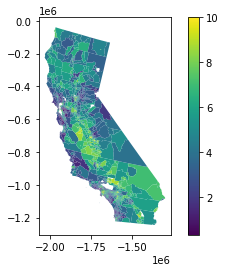

In [64]:
thing = gpd.read_file(base + 'data/calenviroscreen40shpf2021shp/').to_crs(epsg='2163')
thing = thing[thing.PopCharSc != -999]
thing.plot(column='PopCharSc', legend=True)

In [12]:
relevant_vars = ['CIscore',
 'CIscoreP',
 'Ozone',
 'OzoneP',
 'PM2_5',
 'PM2_5_P',
 'DieselPM',
 'DieselPM_P',
 'Pesticide',
 'PesticideP',
 'Tox_Rel',
 'Tox_Rel_P',
 'Traffic',
 'TrafficP',
 'DrinkWat',
 'DrinkWatP',
 'Lead',
 'Lead_P',
 'Cleanup',
 'CleanupP',
 'GWThreat',
 'GWThreatP',
 'HazWaste',
 'HazWasteP',
 'ImpWatBod',
 'ImpWatBodP',
 'SolWaste',
 'SolWasteP',
 'PollBurd',
 'PolBurdSc',
 'PolBurdP',
 'Asthma',
 'AsthmaP',
 'LowBirtWt',
 'LowBirWP',
 'Cardiovas',
 'CardiovasP',
 'Educatn',
 'EducatP',
 'Ling_Isol',
 'Ling_IsolP',
 'Poverty',
 'PovertyP',
 'Unempl',
 'UnemplP',
 'HousBurd',
 'HousBurdP',
 'PopChar',
 'PopCharSc',
 'PopCharP',
 'Child_10',
 'Pop_10_64',
 'Elderly65',
 'Hispanic',
 'White',
 'AfricanAm',
 'NativeAm']